In [1]:

import sklearn
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import random
import matplotlib.patches as patches
import numpy as np
from scipy import integrate
import os,matplotlib
import time,pickle,_pickle
import matplotlib.pyplot as plt
from matplotlib.pylab import rc
import os
import h5py
import math
import os.path
import illustris_python as il
import csv
import copy
from collections import Counter
import pickle
def log10(x):
    if x > 0:
        return math.log10(x)
    else:
        return np.nan

def box_smooth(data_array):
    N = len(data_array)

    data_smooth = []

    for i in range(0, N):
        data_i = data_array[int(np.maximum(i - 1, 0)):int(np.minimum(i + 2, N))]
        # print(np.nanmean(data_i))

        data_smooth.append(np.nanmean(data_i))

    data_smooth = np.array(data_smooth).ravel()
    data_smooth[0] = np.nanmedian(data_array[:1])
    return data_smooth

def bootstrap_scatter_err(samples):
    mask_finite = np.isfinite(samples)
    samples = samples[mask_finite]
    index_all = range(len(samples))
    err_all = []
    N=100
    for i in range(0,N):
        index_choose = np.random.randint(0,len(samples)-1,len(samples))
        # k_i = np.nanstd(samples[index_choose])
        k_i = np.percentile(samples[index_choose],84)-np.percentile(samples[index_choose],16)
        k_i = k_i/2
        err_all.append(k_i)
    err_all = np.array(err_all)
    if len(samples)<0:
        err_all = np.nan

    return err_all


def exp(x):
    try:
        return math.exp(x)
    except:
        return np.inf

def Mpeak_log_to_Vpeak_log(Mpeak_log):
    return 0.3349*Mpeak_log - 1.672

G = 4.301 * 10 ** (-9)
cons = (4 * G * np.pi / (3 * (1 / 24 / (1.5 * 10 ** (11))) ** (1 / 3))) ** 0.5


def calculate_v_dispersion(Mh):
    return Mh ** (1 / 3) * cons


exp = np.vectorize(exp)
log10 = np.vectorize(log10)

####!!!!!!! here are some extreme values:
## Let's use 99 percent of data:


def normalize(x,return_maxmin=False):

    temp_max = np.nanpercentile(x,99)
    temp_min = np.nanpercentile(x, 1)

    if return_maxmin:
        return 2 * (x - temp_min) / (temp_max - temp_min) - 1,temp_max,temp_min
    else:
        return 2 * (x - temp_min) / (temp_max - temp_min) - 1



plot_path = "/Users/caojunzhi/Downloads/upload_201907_Jeremy/"


if os.path.isdir("/Volumes/SSHD_2TB") == True:
    print("The code is on Spear of Adun")

    ## Move to Data_10TB
    data_path = "/Volumes/Data_10TB/"

elif os.path.isdir("/mount/sirocco1/jc6933/test") == True:
    data_path = "/mount/sirocco2/jc6933/Data_sirocco/"
    print("The code is on Sirocco")

# Kratos
elif os.path.isdir("/home/jc6933/test_kratos") == True:
    data_path = "/mount/kratos/jc6933/Data/"
    print("The code is on Kratos")

# Void Seeker
elif os.path.isdir("/home/jc6933/test_Void_Seeker") == True:
    data_path = "/mount/Void_Seeker/Data_remote/"
    print("The code is on Void Seeker")

### PRINCE:
elif os.path.isdir("/home/jc6933/test_folder_prince") == True:
    data_path = "/scratch/jc6933/"
    print("The code is on PRINCE")

else:
    print("The code is on local")
    data_path = "/Volumes/Extreme_SSD/Data/"

print("data_path %s" % data_path)
# read C250:

print("Predicting using C250 data")
hf_Bolshoi = h5py.File(data_path+ "Include_now/" + "C250.h5","r")

### use M_vir!!!
M_vir = np.array(hf_Bolshoi["M_vir"])

V_max_C250 = np.array(hf_Bolshoi["V_max"])
upid = np.array(hf_Bolshoi["upid"])
Vpeak_C250 = np.array(hf_Bolshoi["Vpeak"])
Mpeak = np.array(hf_Bolshoi["Mpeak"])


hf_Bolshoi.close()

#R_vir:
pkl_file = open(data_path + "R_vir_z0_C250.pkl", 'rb')
R_vir_C250 = pickle.load(pkl_file)
pkl_file.close()
pkl_file = open(data_path + "Mpeak/" + "Ms_log_C250_M_peak_combined_v1.pkl", 'rb')
Ms_all_log_C250_Vpeak = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(data_path + "Vrms_C250.pkl", 'rb')
Vrms = pickle.load(pkl_file)
pkl_file.close()

# spin:
pkl_file = open(data_path +"spin_C250.pkl", 'rb')
spin = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(data_path +"spin_bullock_C250.pkl", 'rb')
spin_bullock = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(data_path +"Vrms_C250.pkl", 'rb')
Vrms_C250 = pickle.load(pkl_file)
pkl_file.close()

# to cpkc/h
R_vir_C250 = R_vir_C250*1000*0.7

#Vpeak_log = log10(Vpeak_C250)
Mpeak_log = log10(Mpeak)


n_group = 99

# read TNG100:

# z0:

fields = ['GroupBHMass',"Group_M_Crit200","GroupFirstSub","GroupMassType"]


basePath = data_path+'TNG100/TNG100-1/output'
halos= il.groupcat.loadHalos(basePath,99,fields=fields)
halos.keys()

GroupBHMass = halos['GroupBHMass'] * 1e10 / 0.704
Group_M_Crit200 = halos["Group_M_Crit200"] * 1e10 / 0.704
GroupFirstSub = halos["GroupFirstSub"]
GroupMassType = halos["GroupMassType"]* 1e10 / 0.704

### for subhalo
fields = ['SubhaloMass','SubhaloSFRinRad',"SubhaloVmax","SubhaloStellarPhotometricsMassInRad","SubhaloBHMass","SubhaloGrNr","SubhaloMassInHalfRadType","SubhaloVelDisp"]

basePath = data_path+'TNG100/TNG100-1/output'
subhalos = il.groupcat.loadSubhalos(basePath,99,fields=fields)
subhalos.keys()


mass_msun = subhalos['SubhaloMass'] * 1e10 / 0.704
Vmax = subhalos['SubhaloVmax']
SubhaloStellarPhotometricsMassInRad =subhalos['SubhaloStellarPhotometricsMassInRad'] * 1e10 / 0.704
SubhaloBHMass = subhalos["SubhaloBHMass"]* 1e10 / 0.704
SubhaloGrNr = subhalos["SubhaloGrNr"]
SubhaloMassInHalfRadType = subhalos["SubhaloMassInHalfRadType"]* 1e10 / 0.704
SubhaloVelDisp = subhalos["SubhaloVelDisp"]
# plot and check:

Vmax_halo_z0 = Vmax[GroupFirstSub]
#Ms_halo_z0 = SubhaloStellarPhotometricsMassInRad[GroupFirstSub]
Ms_halo_z0 = SubhaloStellarPhotometricsMassInRad[GroupFirstSub]
SubhaloVelDisp_z0 = SubhaloVelDisp[GroupFirstSub]
## Here we use type 4 instead;
#Ms_halo_z0 = GroupMassType[:,4]
#Ms_halo_z0 = SubhaloMassInHalfRadType[GroupFirstSub,4]

Mh_log_z0 = log10(mass_msun)[GroupFirstSub]
BH_mass_z0 = SubhaloBHMass[GroupFirstSub]



# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

## Add a mask? at logMs=8?
Ms_halo_z0_log = log10(Ms_halo_z0)
# We can change that to 1e9/1e10 since there is no such low mass samples in C250

## since we have enough data, I think it's okay to drop data with nan since the lack of parameters:
Vmax_halo_z0_log = log10(Vmax_halo_z0)


The code is on Void Seeker
data_path /mount/Void_Seeker/Data_remote/
Predicting using C250 data


In [2]:

### XGBOOST:
import time


# try xgboost:
from xgboost import XGBRegressor


### Let's train two models (or more:) ), the first one is good for 1e12 and higher, the otehr is good for others


mask_90 = (Mh_log_z0<14.5)&(Mh_log_z0>11.8)&(np.isfinite(Mh_log_z0+Vmax_halo_z0_log))





X = np.c_[Mh_log_z0[mask_90],Vmax_halo_z0_log[mask_90]]
Y = Ms_halo_z0_log[mask_90]
fusion = np.c_[X,Y]
imp.fit(fusion)
fusion = imp.transform(fusion)


X = fusion[:,:-1]
Y = fusion[:,-1]



# split into 8:2 train test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.2,shuffle=True)

time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 1024
params['tree_method'] = 'gpu_hist'
model_high = XGBRegressor(n_estimators=10000,n_jobs=-1,**params)

model_high.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))

Y_predict_test = model_high.predict(X_test)

print("MAE from high mass model =%.2f"%np.nanmedian(abs(Y_predict_test-y_test)))
### low:


mask_90 = (Mh_log_z0>10)&(Mh_log_z0<12)&(np.isfinite(Mh_log_z0+Vmax_halo_z0_log))




X = np.c_[Mh_log_z0[mask_90],Vmax_halo_z0_log[mask_90]]

Y = Ms_halo_z0_log[mask_90]
fusion = np.c_[X,Y]
imp.fit(fusion)
fusion = imp.transform(fusion)


X = fusion[:,:-1]
Y = fusion[:,-1]



# split into 8:2 train test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.2,shuffle=True)

time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 1024
params['tree_method'] = 'gpu_hist'
model_low = XGBRegressor(n_estimators=10000,n_jobs=-1,**params)

model_low.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))

Y_predict_test = model_low.predict(X_test)

print("MAE from low mass model =%.2f"%np.nanmedian(abs(Y_predict_test-y_test)))


###### test and plot scatter:

# predict ,R_vir_C250

M_vir_log = log10(M_vir)
Vpeak_log = log10(Vpeak_C250)
mask_upid = (upid<0)&(np.isfinite(Mpeak_log+Vpeak_log))
X_test_C250 = np.c_[Mpeak_log[mask_upid],log10(Vpeak_C250[mask_upid])]
#X_test_imp = imp.transform(X_test_C250)
Y_predict_C250_high = model_high.predict(X_test_C250)
# imp = SimpleImputer(missing_values=np.nan, strategy='constant',fill_value=0)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_test_C250)

# Inpute our data, then train: get rid of nan values
X_test_C250 = np.c_[M_vir_log[mask_upid],log10(V_max_C250[mask_upid])]
#X_test_imp = imp.transform(X_test_C250)

Y_predict_C250_low = model_low.predict(X_test_C250)

Y_predict_C250 = Y_predict_C250_high
mask_low = X_test_C250[:,0]<12
Y_predict_C250[mask_low] = Y_predict_C250_low[mask_low]
# save it:
# pickle.dump(Y_predict_C250, open(data_path+"random_forest/"+"C250_Ms_bagging_v1.pkl","wb"))

N = len(Y_predict_C250)

print("MAE =%.2f"%np.nanmedian(abs(Y_predict_test-y_test)))

## We can not compare this data to Ms fromSHAM in Vpeak since they are from different mechanism


#### scatter plot:

# TNG100:
scatter_Ms_Vpeak_TNG100 = []
scatter_Ms_Vpeak_TNG100_err = []
Mh_log = Mh_log_z0
binsize=0.05
Ms_all_log_i = Ms_halo_z0_log
x = np.linspace(10, 15, 500)
Mh_target_log = x = np.linspace(10, 15, 51)
y = []
for i in range(0, len(x)):
    mask_i = (Mh_log > x[i] - binsize) & (Mh_log < x[i] + binsize)
    y.append(np.nanmedian(Ms_all_log_i[mask_i]))

y = np.array(y)
mask_finite = np.isfinite(x + y)
poly_Ms_from_Mh = np.poly1d(np.polyfit(x[mask_finite], y[mask_finite], 10))

for i in range(0, len(Mh_target_log)):

    mask_Vpeak = (Mh_log > Mh_target_log[i] - binsize) & (Mh_log < Mh_target_log[i] + binsize)

    if len(Ms_all_log_i[mask_Vpeak]) > 10:
        sample_select = Ms_all_log_i[mask_Vpeak] - poly_Ms_from_Mh(Mh_log[mask_Vpeak])
        mask_finite_i = np.isfinite(sample_select)
        sample_select = sample_select[mask_finite_i]
        scatter_Ms_Vpeak_TNG100.append((np.percentile(sample_select, 84) - np.percentile(sample_select, 16)) / 2)
        scatter_Ms_Vpeak_TNG100_err.append(np.nanstd(bootstrap_scatter_err(samples=sample_select)))
    else:
        scatter_Ms_Vpeak_TNG100.append(np.nan)
        scatter_Ms_Vpeak_TNG100_err.append(np.nan)

# now we get the intrinsic scatter between Vpeak and Mpeak. Let's derive the scatter of...
scatter_Ms_Vpeak_TNG100 = np.array(scatter_Ms_Vpeak_TNG100)
scatter_Ms_Vpeak_TNG100_err = np.array(scatter_Ms_Vpeak_TNG100_err)



## from tree



scatter_Ms_Vpeak_C250 = []
scatter_Ms_Vpeak_C250_err = []
Mh_log =X_test_C250[:,0]
binsize=0.05
Ms_all_log_i = Y_predict_C250
x = np.linspace(10, 15, 500)
Mh_target_log = x = np.linspace(10, 15, 51)
y = []
for i in range(0, len(x)):
    mask_i = (Mh_log > x[i] - binsize) & (Mh_log < x[i] + binsize)
    y.append(np.nanmedian(Ms_all_log_i[mask_i]))

y = np.array(y)
mask_finite = np.isfinite(x + y)
poly_Ms_from_Mh = np.poly1d(np.polyfit(x[mask_finite], y[mask_finite], 10))

for i in range(0, len(Mh_target_log)):

    mask_Vpeak = (Mh_log > Mh_target_log[i] - binsize) & (Mh_log < Mh_target_log[i] + binsize)

    if len(Ms_all_log_i[mask_Vpeak]) > 10:
        sample_select = Ms_all_log_i[mask_Vpeak] - poly_Ms_from_Mh(Mh_log[mask_Vpeak])
        mask_finite_i = np.isfinite(sample_select)
        sample_select = sample_select[mask_finite_i]
        scatter_Ms_Vpeak_C250.append((np.percentile(sample_select, 84) - np.percentile(sample_select, 16)) / 2)
        scatter_Ms_Vpeak_C250_err.append(np.nanstd(bootstrap_scatter_err(samples=sample_select)))
    else:
        scatter_Ms_Vpeak_C250.append(np.nan)
        scatter_Ms_Vpeak_C250_err.append(np.nan)

# now we get the intrinsic scatter between Vpeak and Mpeak. Let's derive the scatter of...
scatter_Ms_Vpeak_C250 = np.array(scatter_Ms_Vpeak_C250)
scatter_Ms_Vpeak_C250_err = np.array(scatter_Ms_Vpeak_C250_err)



[09:55:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time it takes using GPU=119.57
MAE from high mass model =0.09
[09:57:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Time it takes using GPU=119.61
MAE from low mass model =0.26
MAE =0.26


/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1076: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


/home/jc6933/anaconda3/envs/tf14/lib/python3.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


Text(0, 0.5, '$\\sigma [Ms|Mh]$')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


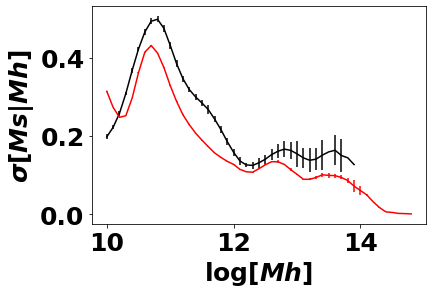

In [3]:
%matplotlib inline
## plot:


color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

font = {'family': 'normal',
        'weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)

#plt.plot(Mh_target_log,box_smooth(box_smooth(scatter_Ms_Vpeak_TNG100)),"k",label="TNG100")

#plt.plot(Mh_target_log,box_smooth(box_smooth(scatter_Ms_Vpeak_C250)),"r",label="C250 predicted")

plt.errorbar(x=Mh_target_log,y=box_smooth(box_smooth(scatter_Ms_Vpeak_TNG100)),yerr=scatter_Ms_Vpeak_TNG100_err,color="k",label="TNG100")
plt.errorbar(x=Mh_target_log,y=box_smooth(box_smooth(scatter_Ms_Vpeak_C250)),yerr=scatter_Ms_Vpeak_C250_err,color="r",label="C250 predicted")

plt.xlabel(r"$\log [Mh]$")
plt.ylabel(r"$\sigma [Ms|Mh]$")


In [ ]:
# also show fitting goodness for TNG100 stellar mass:

### XGBOOST:
import time


# try xgboost:
from xgboost import XGBRegressor


### Let's train two models (or more:) ), the first one is good for 1e12 and higher, the otehr is good for others


mask_90 = (Mh_log_z0<14.5)&(Mh_log_z0>12)&(np.isfinite(Mh_log_z0+Vmax_halo_z0_log))





X = np.c_[Mh_log_z0[mask_90],Vmax_halo_z0_log[mask_90]]
Y = Ms_halo_z0_log[mask_90]
fusion = np.c_[X,Y]
imp.fit(fusion)
fusion = imp.transform(fusion)


X = fusion[:,:-1]
Y = fusion[:,-1]



# split into 8:2 train test:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,Y, test_size=0.2,shuffle=True)

time_start = time.time()
params={}
params['gpu_id'] = 0
params['max_bin'] = 1024
params['tree_method'] = 'gpu_hist'
model_high = XGBRegressor(n_estimators=3000,n_jobs=-1,**params)

model_high.fit(X_train,y_train)
# predict:


print("Time it takes using GPU=%.2f"%(time.time()-time_start))

Y_predict_test = model_high.predict(X_test)

print("MAE from high mass model =%.2f"%np.nanmedian(abs(Y_predict_test-y_test)))

## plot:



findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


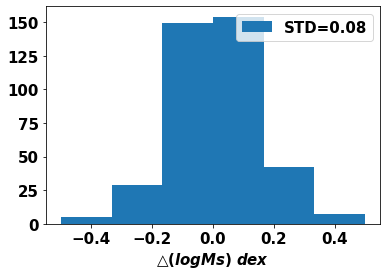

In [5]:


color_array = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

font = {'family': 'normal',
        'weight': 'bold',
        'size': 15}

matplotlib.rc('font', **font)

#plt.plot(Mh_target_log,box_smooth(box_smooth(scatter_Ms_Vpeak_TNG100)),"k",label="TNG100")

#plt.plot(Mh_target_log,box_smooth(box_smooth(scatter_Ms_Vpeak_C250)),"r",label="C250 predicted")
plt.hist(Y_predict_test-y_test,label="STD=%.2f"%np.nanmedian(abs(Y_predict_test-y_test)),bins=np.linspace(-0.5,0.5,7))
plt.xlabel(r"$\bigtriangleup (logMs)$ $dex$")

plt.legend()